In [1]:
## Importing standards libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
#import torch


## Importing libraries for the Gaussian Mixture Model

from scipy.stats import multivariate_normal
from scipy.stats import norm
import seaborn as sns


## Convergence metrics

from scipy.stats import wasserstein_distance
from scipy.stats import entropy # KL-divergence


## Import functions for the experiment : 

from experiment_functions import *
from IPLA_Exp_Functions import *
from IPLA_functions_MMLE_V2 import *


### Setting of the Experiment

In this Notebook, we consider the same setting as previously with the same Latent Variable Model :


- $\mathbf{y} = H^{*}\mathbf{x} + \mathbf{z}$ where:
- $\mathbf{y} \in \mathbb{R}$ is the observed data,
- $H^{*} \in \mathbb{R}^{dx}$ is the "ground truth" parameter that links the latent variables and the observed data.

To generate $\mathbf{y}$, the observed data, we first draw $x^{*} \sim p_{\theta}$ and set $\mathbf{y} := H^{*}x + \mathbf{z}$, where $\mathbf{z} \sim \mathcal{N}(0, \sigma_y^{2})$ 

For a given dimension $d_x$, we consider the prior distribution $p_\theta$, which is a mixture of $K := 25$ Gaussian random variables. The components have mean $\mu_{i,j} := (8i, 8j, \ldots, 8i, 8j) \in \mathbb{R}^{d_x}$ for $(i, j) \in \{-2, -1, 0, 1, 2\}^2$ and unit variance. We have set that $\theta = (\omega_{i}), {i} \in \{1, ..., K\}$ the normalized weights of the Mixture : $d_\theta = K$. 

This choice of Parametric Model is convenient because it allows the Posterior Distribution to stay in the same parametric family of distribution : it is a Gaussian Mixture. AND it allows us to have a computable closed form for the marginal distribution of $y$. 

The joint density of the variables, $ p_\theta(x, y) $, is given by : $ p_\theta(x, y) = p(y \mid x) p_{\theta}(x) $, where : 
- $ p(y \mid x) = \mathcal{N}(y \mid H^{*}x, \sigma_y^2)$
- $ p_{\theta}(x) = \sum_{k=1}^K \theta_k . \mathcal{N}(x \mid \mu_k, I) $

But here, we would like to estimate the Maximum Marginal Likelihood of the model given one observations $y_{obs} \in \mathbb{R}$, which correspond to : 

\begin{equation}
\theta^\ast \in \arg \max_{\theta \in \mathbb{R}^{d_\theta}} \log p_\theta(y),
\end{equation}

In order to do that, we implement several algorithms and compare their efficiency through different examples : 
- Particle Gradient Descent
- Interacting Particle Langevin Algorithm from the "[Interacting Particle Langevin Algorithm for Maximum Marginal
Likelihood Estimation](https://arxiv.org/pdf/2303.13429)"
- Interacting Particle Langevin Algorithm with Dilation Path, inspired from the idea of a convolutional path for ULA in "[A Practical Diffusion Path for Sampling](https://arxiv.org/abs/2406.14040)"

We set $H^{*} = (-1, 1, ..., -1, 1) \in \mathbb{R}^{dx}$ and in this example, given the value of $H^{*}$ we can compute the marginal law of $y$ by a convolution product : 

Thus, the marginal distribution $ p_\theta(y) $ is a mixture of Gaussians:

$
p_\theta(y) = \sum_{k=1}^K \theta_k . \mathcal{N}(y \mid H^* \mu_k, H^* I H^{*\top} + \sigma_y^2).
$

Then, with a set of $N \in \mathbb{N}$ observations $\{Y_1, ..., Y_N\}$, we can proceed to the estimation of the Maximum Marginal Likelihood with interacting methods. 

------------------------------------------------------------------------------------------------------------------------------------------
First of all, we confirm that the different variants of ULA are efficient to sample from the posterior distribution : 
$p_\theta(x \mid y) \propto p_\theta(x).p(y \mid x)$

No handles with labels found to put in legend.


Shape of means array: (25, 10)
Unit Covariance Matrix: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Weights vector : [0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04]


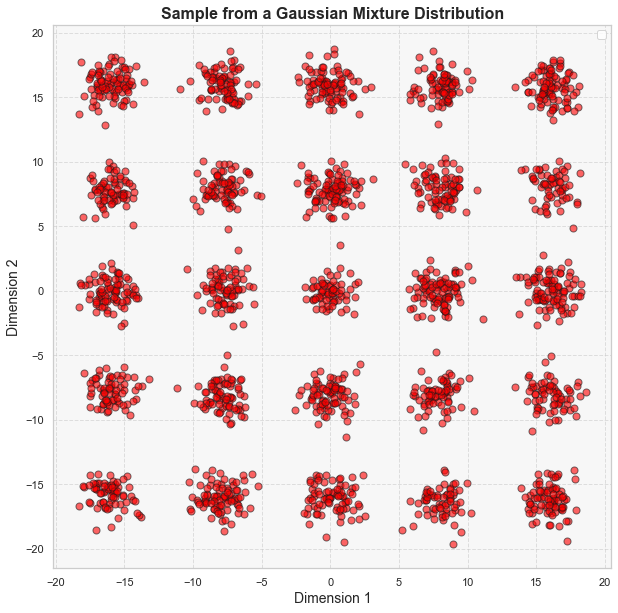

In [30]:
centers_prior, covariances_prior, weights_prior = gen_prior_param(10, 16, 0, 0)

sample_prior = sample_prior_dx(2000, centers_prior, covariances_prior, weights_prior)
plot_sample_dx(sample_prior)

We set the other parametres of the experiment : 

- Known Operator : $H^*$
- Known Variance of observed date $y$ : $\sigma_y$
- Known parameters of the prior distribution : $(\mu_i)_i$ and $(\Sigma_i)_i$, for $i \in {1, ..., K}$ 
- Unknown parameter $\theta^* = (\omega_i^*)_i$ that we want to estimate -> gives information on the distribution of observed data


In [44]:
dx = 10
H_star = np.tile([-1, 1], 5)
sigma_y = 0.1

unnormalized_weights =  np.random.exponential(1, 25)

theta_star = unnormalized_weights / np.sum(unnormalized_weights)

Distribution of the latent variables with the right parameter $\theta^*$

No handles with labels found to put in legend.


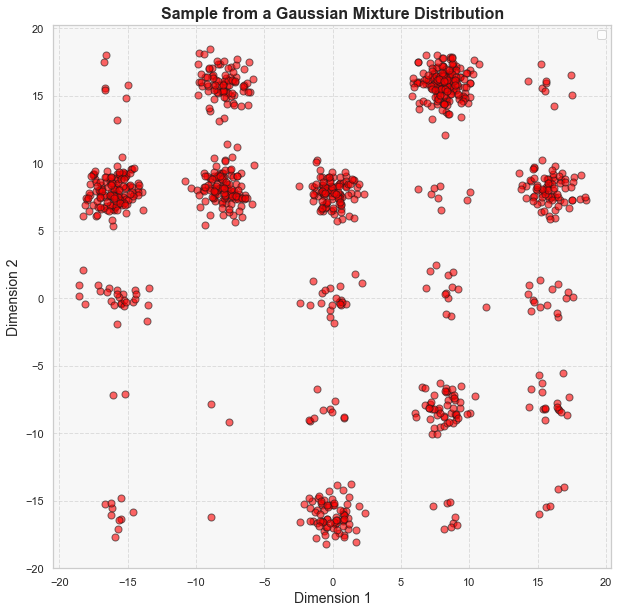

In [45]:
plot_sample_dx(sample_prior_dx(1000, centers_prior, covariances_prior, theta_star))

In [72]:
x_star = sample_prior_dx(1, centers_prior, covariances_prior, theta_star)

y_obs = np.dot(H_star, x_star.T) + np.random.normal(0, sigma_y, 1) ## A voir le carré de ça ou pas ?????? POUR LA VARIANCE

y_obs

array([39.03959086])

IL FAUT S'ASSURER QUE DANS CE CADRE LÀ LES PARAMÈTRES DE LA POSTERIOR DISTRIBUTION SOIENT BIEN CALCULÉS DE LA MÊME FAÇON QUE PRÉCÉDEMMENT MAIS A PRIORI C'EST BON

Here is the true posterior distribution of the model for $\theta^*$ vs the initial posterior obtained with equiponderated weigths : 

No handles with labels found to put in legend.


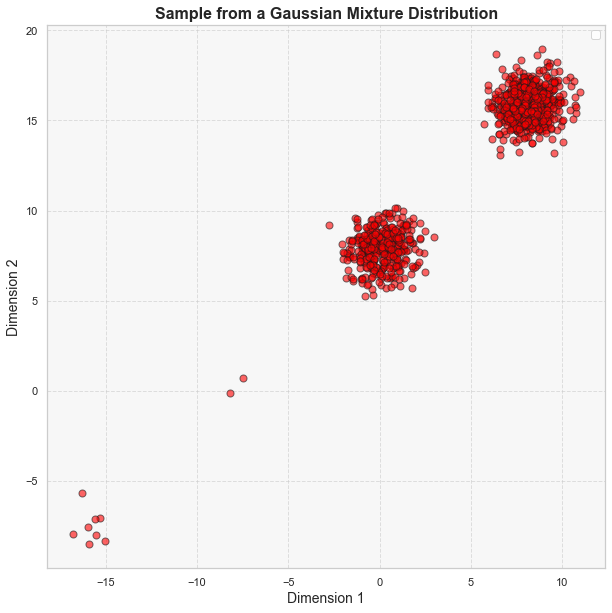

No handles with labels found to put in legend.


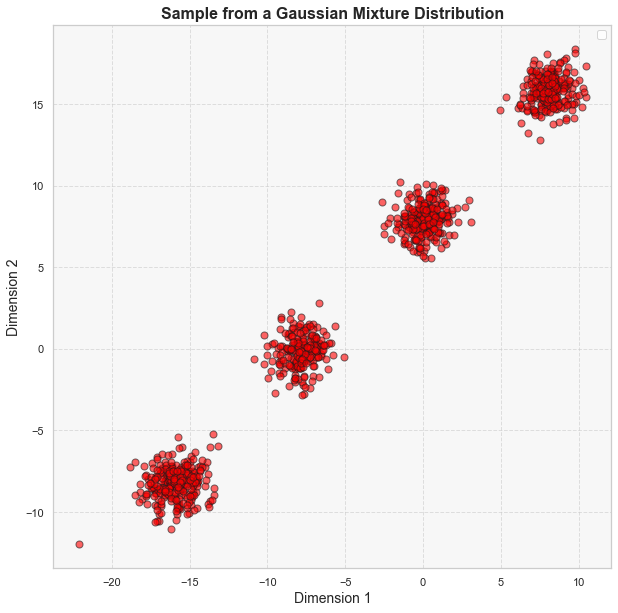

In [74]:
centers_truepost, covariances_truepost, weights_truepost = post_params_dx(H_star, sigma_y, centers_prior, covariances_prior, theta_star, y_obs, plot = True)
centers_post, covariances_post, weights_post = post_params_dx(H_star, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs, plot = True)

plot_sample_dx(sample_prior_dx(1000, centers_truepost, covariances_truepost, weights_truepost))

plot_sample_dx(sample_prior_dx(1000, centers_post, covariances_post, weights_post)) 

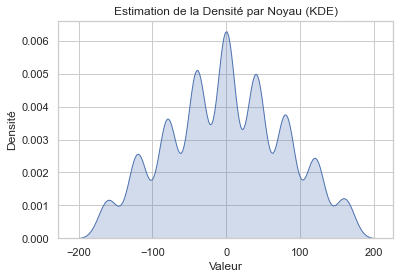

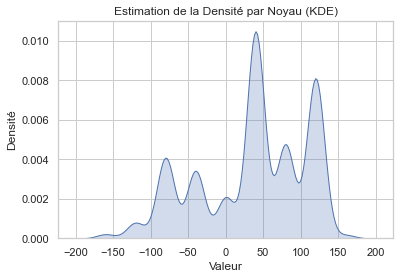

In [76]:
y_obs_list = np.zeros(10000)

for i in range(10000):

    x_star = sample_prior_dx(1, centers_prior, covariances_prior, weights_prior)

    y_obs_list[i] = np.dot(H_star, x_star.T) + np.random.normal(0, sigma_y, 1)

sns.kdeplot(y_obs_list, fill=True)
plt.title('Estimation de la Densité par Noyau (KDE)')
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.show()

for i in range(10000):

    x_star = sample_prior_dx(1, centers_prior, covariances_prior, theta_star)

    y_obs_list[i] =  np.dot(H_star, x_star.T) + np.random.normal(0, sigma_y, 1)

sns.kdeplot(y_obs_list, fill=True)
plt.title('Estimation de la Densité par Noyau (KDE)')
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.show()

Therefore, it seems that with a certain number of observations, it will be possible to strongly estimate the MML (only with one dimensional observations). 

------------------------------------------------------------------------------------------------------------------------------------------
Another time, we try to sample efficiently from the true posterior distribution with different variants of Unadjusted Langevin Algorithm : 

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:27<00:00, 108.84it/s]


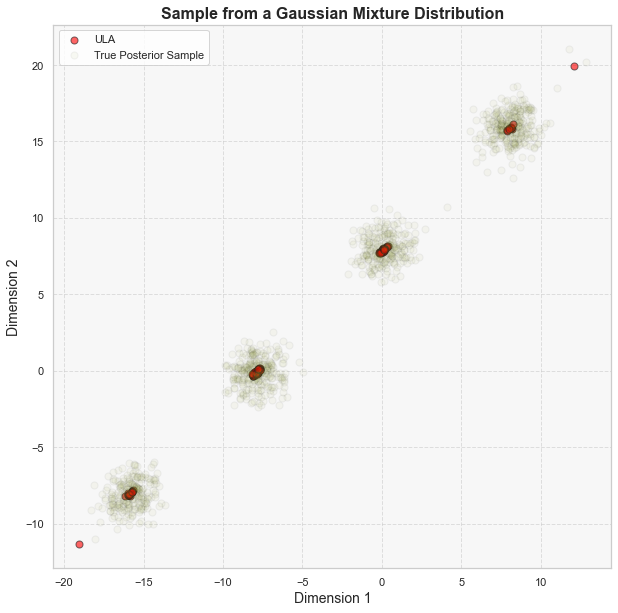

array([[-8.08440057e+00, -2.08581964e-01, -8.14722572e+00,
        -3.14288155e-01, -8.12003996e+00, -3.34649407e-01,
        -8.03314516e+00, -3.27365984e-01, -8.12617486e+00,
        -2.85550449e-01],
       [-7.82197360e+00, -1.32292148e-01, -7.95343596e+00,
        -5.23474419e-02, -7.90920477e+00, -9.43897048e-02,
        -7.92230326e+00, -3.08047422e-02, -7.94641038e+00,
        -2.02943618e-01],
       [ 8.16452660e+00,  1.58204664e+01,  8.04813992e+00,
         1.60159319e+01,  8.05569270e+00,  1.58512572e+01,
         8.10468841e+00,  1.58930870e+01,  8.09188679e+00,
         1.59247422e+01],
       [ 8.83707322e-02,  7.98618779e+00,  1.92280126e-01,
         7.89395289e+00,  1.17163968e-01,  7.84217648e+00,
         3.87268586e-02,  7.93179064e+00,  1.31064190e-01,
         7.95404838e+00],
       [-7.91892176e+00, -1.05774654e-01, -7.93375109e+00,
        -6.87057613e-02, -7.98492136e+00, -1.21612451e-01,
        -7.93263778e+00, -4.43568138e-02, -7.73596171e+00,
        -1.

In [98]:
sample_init = sample_prior_dx(100, centers_prior, covariances_prior, weights_prior)

grad_descent_post_dx(sample_init, 0.001, 3000, centers_prior, covariances_prior, weights_prior, y_obs, sigma_y, H_star, plot = True)

Here, it is just the "true" posterior distribution, i.e with the "true" parameter $\theta^*$

We compare the performance of several step sizes but the same number of iterations to converge to the modes of the distribution for the gradient descent (i.e without noise)

In [117]:
def grad_descent_post_dx(sample_init, step_size, nb_iter, centers_prior, covariances_prior, weights_prior, y_obs, sigma_y, true_theta, plot = True): 

    sample_size = sample_init.shape[0]
    dim_var = sample_init.shape[1]

    traj = np.zeros((nb_iter, sample_size, dim_var))

    centers_post, covariances_post, weights_post = post_params_dx(true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
    grad = np.zeros((sample_size, dim_var))
    for i in tqdm(range(nb_iter)): 
        
        #grad = grad_multimodal_opti(sample_init, weights_post, centers_post, covariances_post)
        grad = ((1/sigma_y**2) * true_theta[:, np.newaxis] * (y_obs - np.dot(true_theta, sample_init.T))).T 

        grad += grad_multimodal_opti(sample_init, weights_prior, centers_prior, covariances_prior)
        #grad += np.nan_to_num(grad_multimodal_opti(sample_init, weights_prior, centers_prior, covariances_prior), nan = 0)

        sample_init += step_size * grad # + np.sqrt(step_size * 2) * np.random.randn(sample_size, dim_var)

        traj[i] = sample_init

    if plot : 

        centers_post, covariances_post, weights_post = post_params_dx(true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
        
        sample_post = sample_prior_dx(1000, centers_post, covariances_post, weights_post)
        
        plot_sample_dx(sample_init, "Gradient Descent", sample_post, "True Posterior Sample") 

    return sample_init

 59%|█████▉    | 1778/3000 [00:12<00:06, 177.00it/s]/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/Interacting Particles - MMLE/experiment_functions.py:124: RuntimeWarning: divide by zero encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
 62%|██████▏   | 1859/3000 [00:13<00:07, 147.47it/s]/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/Interacting Particles - MMLE/experiment_functions.py:124: RuntimeWarning: invalid value encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
100%|██████████| 3000/3000 [00:20<00:00, 149.83it/s]


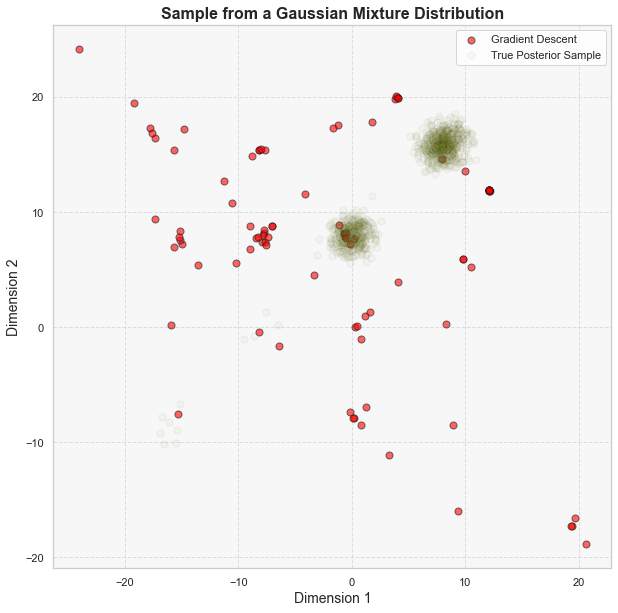

100%|██████████| 3000/3000 [00:25<00:00, 119.96it/s]


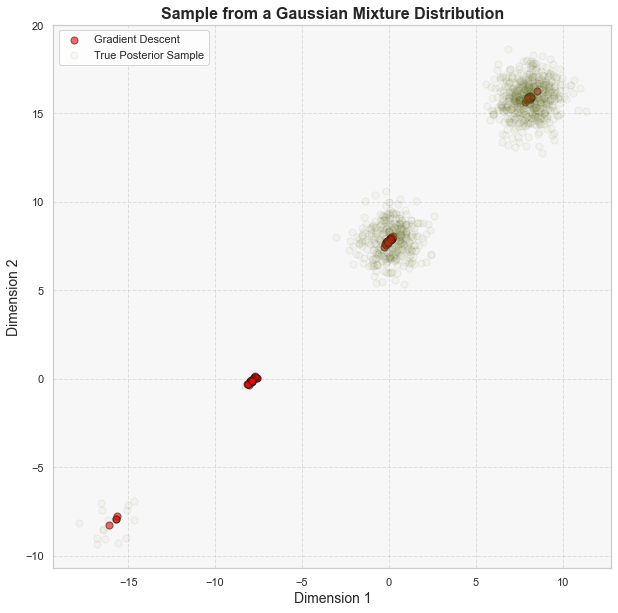

100%|██████████| 3000/3000 [00:22<00:00, 132.80it/s]


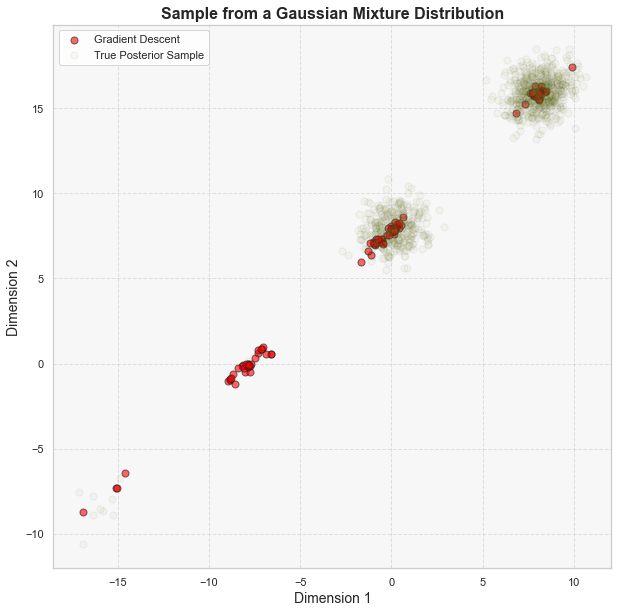

100%|██████████| 3000/3000 [00:24<00:00, 120.08it/s]


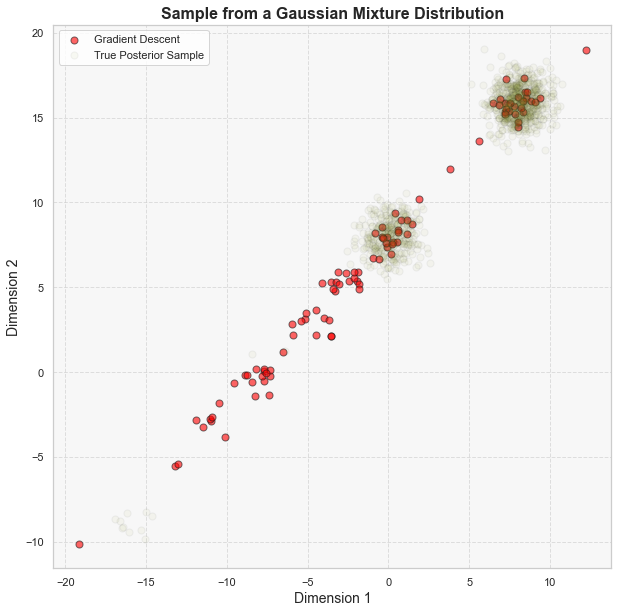

100%|██████████| 3000/3000 [00:39<00:00, 76.51it/s] 


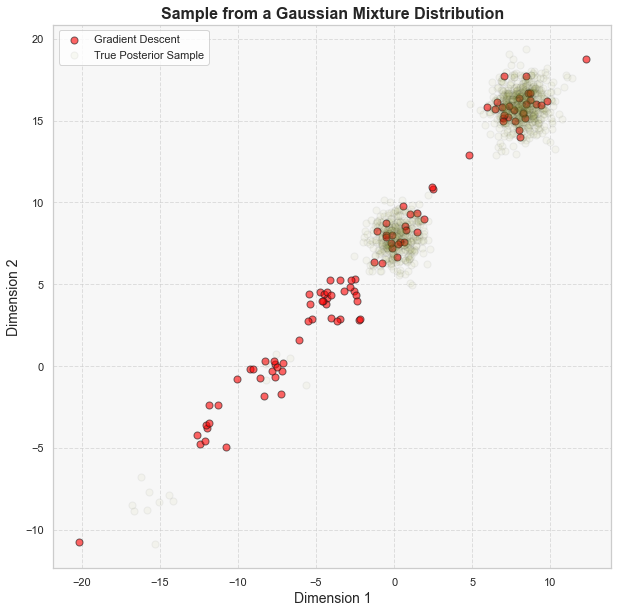

array([[-1.19763105e+01, -3.77205317e+00, -1.19568422e+01,
        -5.42605509e+00, -1.13001337e+01, -3.00384976e+00,
        -1.21356651e+01, -3.70441364e+00, -1.10389721e+01,
        -3.46237469e+00],
       [ 1.00863545e+00,  9.28662780e+00,  1.09333621e+00,
         6.61576495e+00, -5.89588889e-01,  8.09881041e+00,
         4.20655199e-01,  8.01678978e+00,  4.60045853e-01,
         9.41564119e+00],
       [-7.62895662e+00,  1.03462956e-01, -8.61625585e+00,
         3.94255381e-01, -9.05396416e+00, -1.06043767e+00,
        -7.66440724e+00, -3.58866579e-02, -6.06527962e+00,
         6.10292817e-01],
       [ 9.79000438e+00,  1.62273153e+01,  7.48553594e+00,
         1.50189206e+01,  8.13485429e+00,  1.68248476e+01,
         6.46395299e+00,  1.53344204e+01,  7.34604668e+00,
         1.48554407e+01],
       [-1.23989078e+01, -4.76783876e+00, -1.02313947e+01,
        -4.96951098e+00, -1.21799497e+01, -5.35167863e+00,
        -1.36684964e+01, -4.41929257e+00, -1.37258639e+01,
        -3.

In [118]:
sample_init = sample_prior_dx(100, centers_prior, covariances_prior, theta_star)

grad_descent_post_dx(np.copy(sample_init), 0.002, 3000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, plot = True)
grad_descent_post_dx(np.copy(sample_init), 0.001, 3000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, plot = True)
grad_descent_post_dx(np.copy(sample_init), 0.0005, 3000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, plot = True)
grad_descent_post_dx(np.copy(sample_init), 0.0001, 3000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, plot = True)
grad_descent_post_dx(np.copy(sample_init), 0.00001, 3000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, plot = True)

Then, we just want to see how much having a little step is a problem for the convergence : 

100%|██████████| 100/100 [00:00<00:00, 129.45it/s]


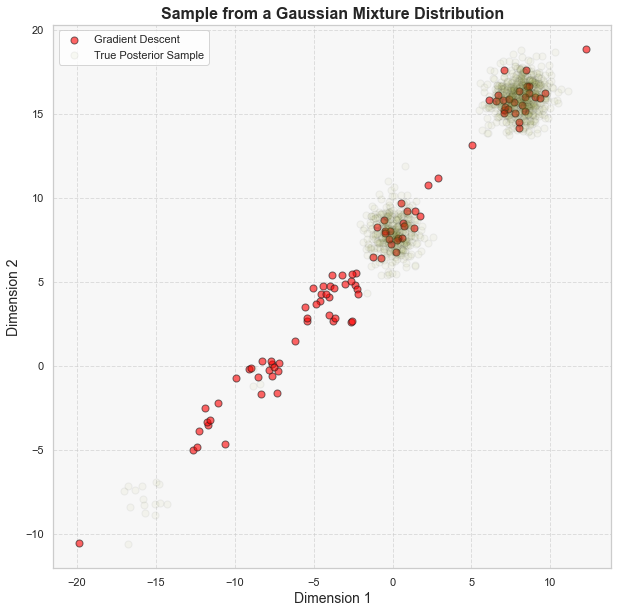

100%|██████████| 1000/1000 [00:09<00:00, 109.87it/s]


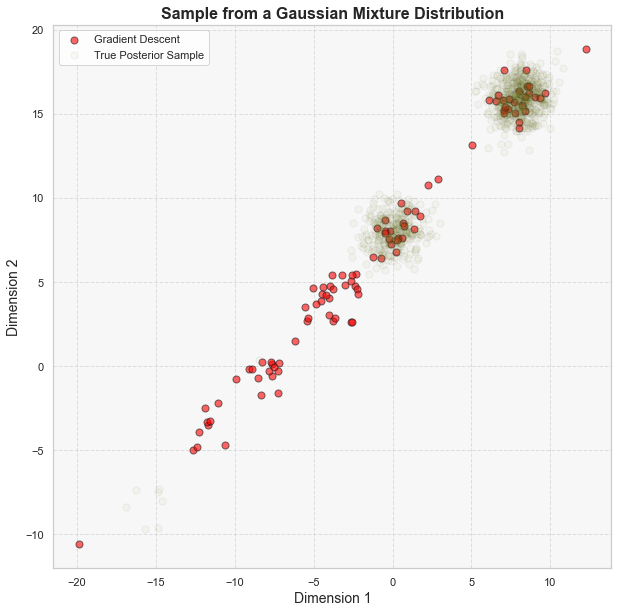

100%|██████████| 10000/10000 [01:25<00:00, 117.31it/s]


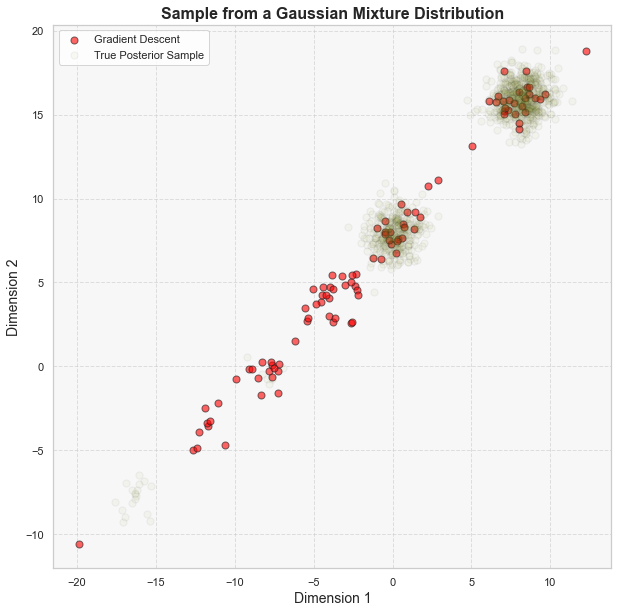

array([[-1.17018913e+01, -3.52416004e+00, -1.16837391e+01,
        -5.06634067e+00, -1.10714284e+01, -2.80789219e+00,
        -1.18504725e+01, -3.46109339e+00, -1.08279230e+01,
        -3.23541785e+00],
       [ 9.46931635e-01,  9.19315688e+00,  1.02590607e+00,
         6.70286174e+00, -5.43242340e-01,  8.08564368e+00,
         3.98702675e-01,  8.00916818e+00,  4.35430265e-01,
         9.31344813e+00],
       [-7.64755506e+00,  8.99816829e-02, -8.56810644e+00,
         3.61114648e-01, -8.97622282e+00, -9.95231689e-01,
        -7.68060899e+00, -3.99469905e-02, -6.18959280e+00,
         5.62546548e-01],
       [ 9.67547495e+00,  1.62054608e+01,  7.52680356e+00,
         1.50787614e+01,  8.13222377e+00,  1.67625960e+01,
         6.57428626e+00,  1.53729314e+01,  7.39674468e+00,
         1.49263339e+01],
       [-1.26358786e+01, -4.99284039e+00, -1.06149034e+01,
        -5.18087826e+00, -1.24317235e+01, -5.53720888e+00,
        -1.38196347e+01, -4.66785820e+00, -1.38731238e+01,
        -3.

In [119]:
grad_descent_post_dx(np.copy(sample_init), 0.001, 100, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, plot = True)
grad_descent_post_dx(np.copy(sample_init), 0.0001, 1000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, plot = True)
grad_descent_post_dx(np.copy(sample_init), 0.00001, 10000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, plot = True)

???????????? -> se renseigner sur comment ça se comporte avec des pas très petits -> est ce que ça converge jamais vraiment bien ou est ce que si mais du coup c'est juste trop lent => auquel cas il faudra faire attention avec des trop petits pas sur le theta (hot/cold)

Revoir toutes les sorties plus haut qui sont très informatrices pour la suite en terme d'ordre de grandeur des pas; 

  0%|          | 0/2000 [00:00<?, ?it/s]

 19%|█▉        | 380/2000 [00:13<00:36, 44.11it/s]/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/Interacting Particles - MMLE/experiment_functions.py:124: RuntimeWarning: divide by zero encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
 22%|██▏       | 439/2000 [00:16<01:07, 23.13it/s]/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/Interacting Particles - MMLE/experiment_functions.py:124: RuntimeWarning: invalid value encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
100%|██████████| 2000/2000 [00:55<00:00, 36.10it/s]


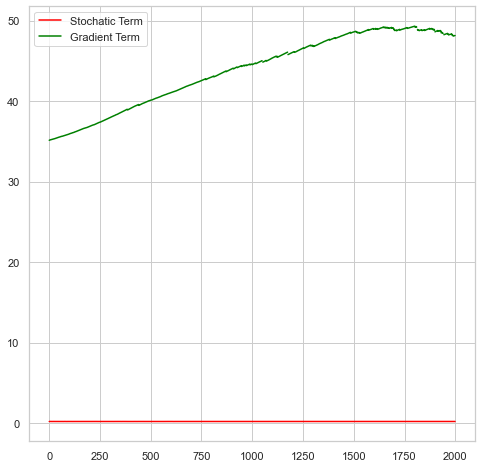

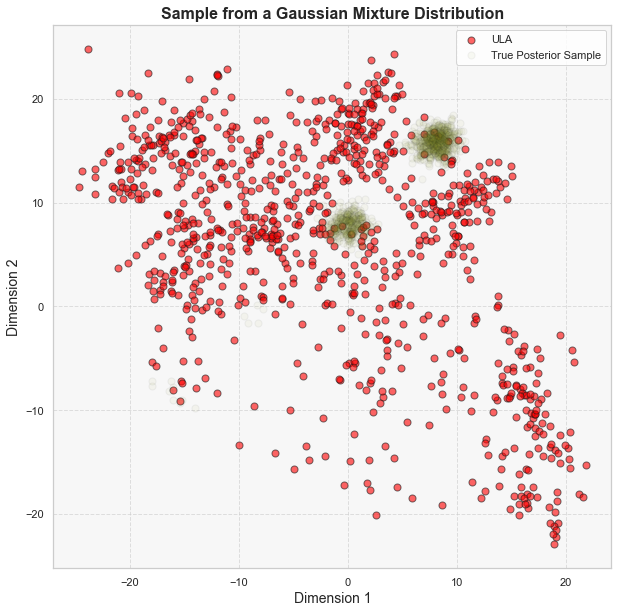

100%|██████████| 2000/2000 [00:40<00:00, 49.18it/s]


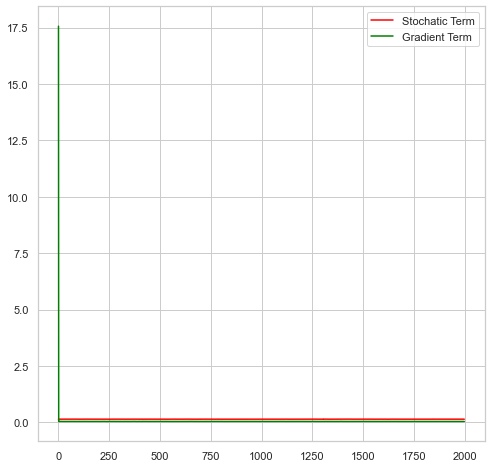

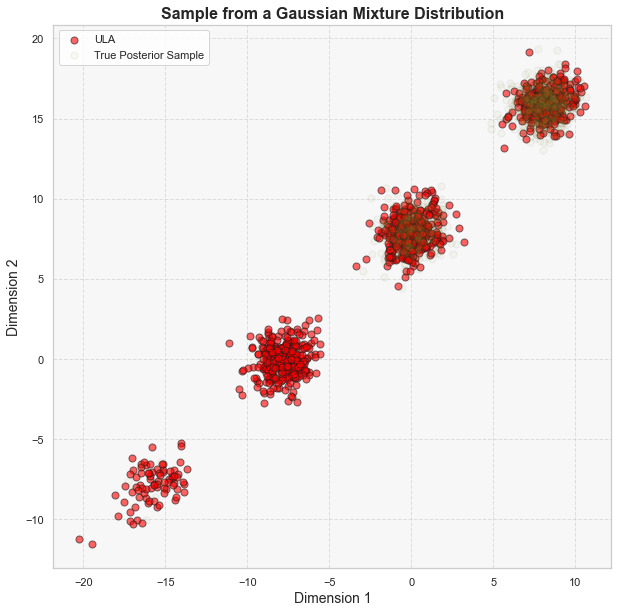

100%|██████████| 2000/2000 [00:53<00:00, 37.61it/s]


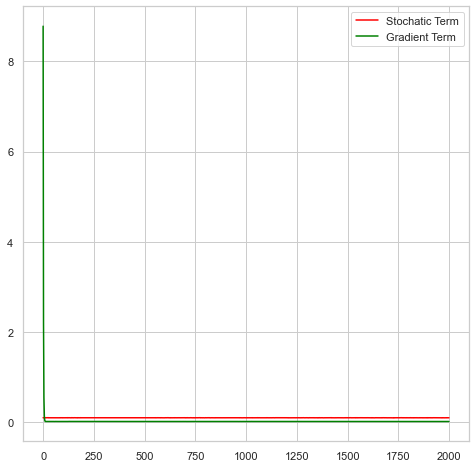

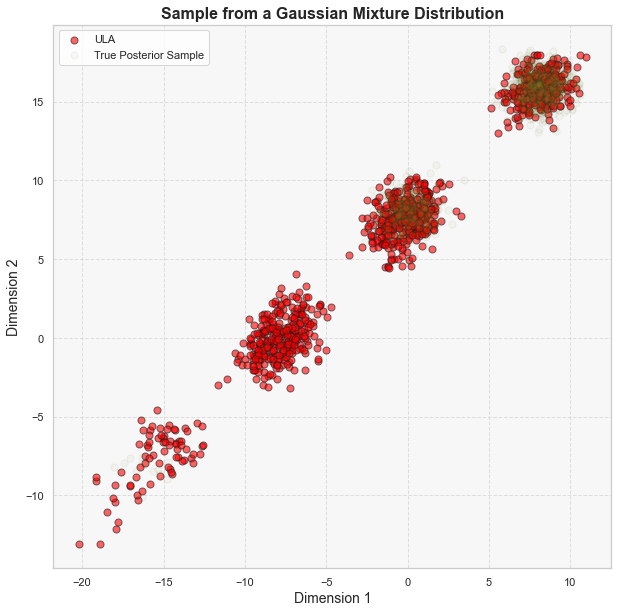

100%|██████████| 2000/2000 [00:56<00:00, 35.59it/s]


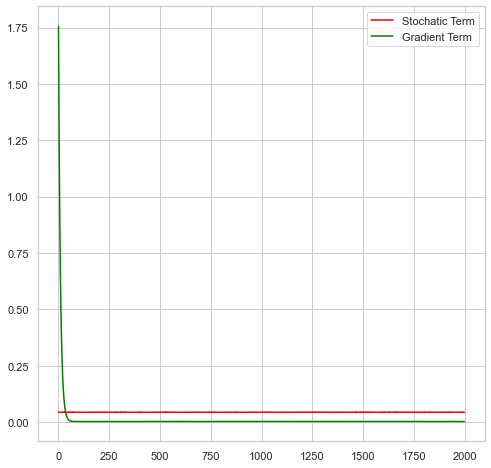

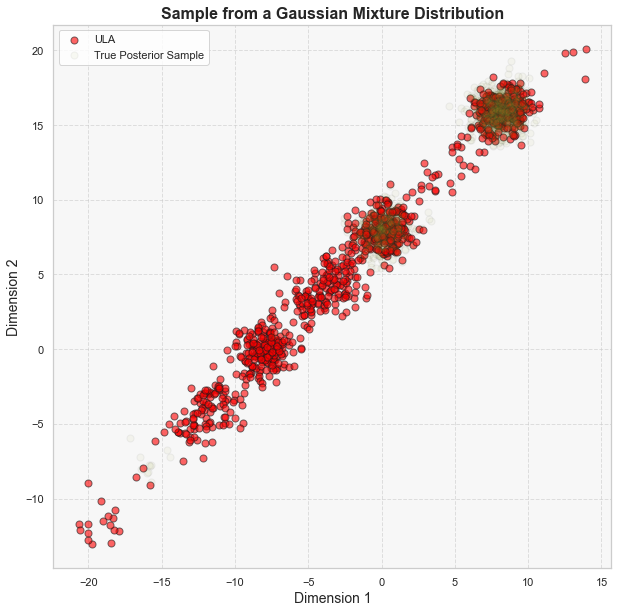

100%|██████████| 2000/2000 [00:55<00:00, 35.77it/s]


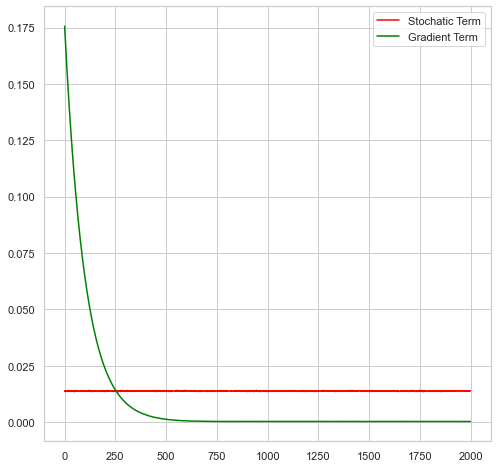

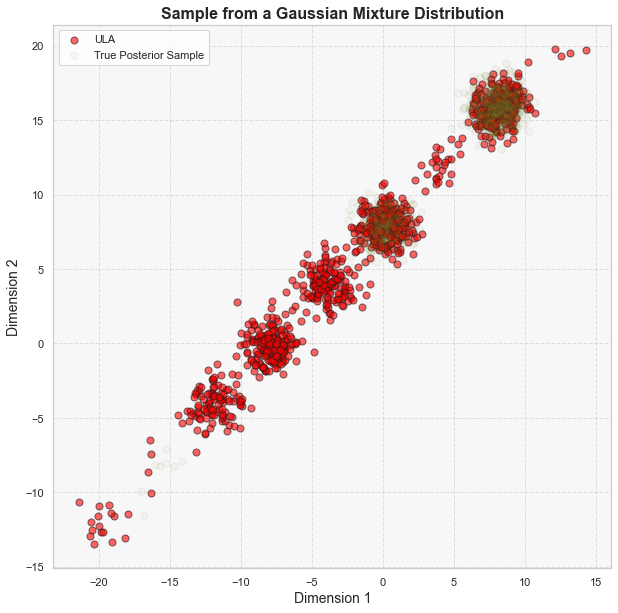

array([[ 1.45643979,  9.42861233, -0.10729478, ...,  8.16077342,
         0.23662204,  6.53655204],
       [-8.07408934, -0.15678663, -8.30333624, ...,  1.17194178,
        -9.67962847, -3.01257159],
       [-8.12697195, -0.80178733, -6.57590908, ...,  1.05133072,
        -8.44825875, -0.40679121],
       ...,
       [-7.21953553, -0.41246799, -8.64369451, ...,  0.96235382,
        -8.76583968, -1.5583962 ],
       [ 8.18119556, 15.51230447,  7.43422233, ..., 15.30760937,
         7.24068207, 15.78942002],
       [-5.41461966,  2.09645172, -3.8857349 , ...,  2.5305207 ,
        -4.66460051,  3.03872717]])

In [122]:
sample_init = sample_prior_dx(1000, centers_prior, covariances_prior, theta_star)

ULA_post_dx(np.copy(sample_init), 0.002, 2000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, plot = True)
ULA_post_dx(np.copy(sample_init), 0.001, 2000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, plot = True)
ULA_post_dx(np.copy(sample_init), 0.0005, 2000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, plot = True)
ULA_post_dx(np.copy(sample_init), 0.0001, 2000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, plot = True)
ULA_post_dx(np.copy(sample_init), 0.00001, 2000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, plot = True)

100%|██████████| 100/100 [00:01<00:00, 52.32it/s]


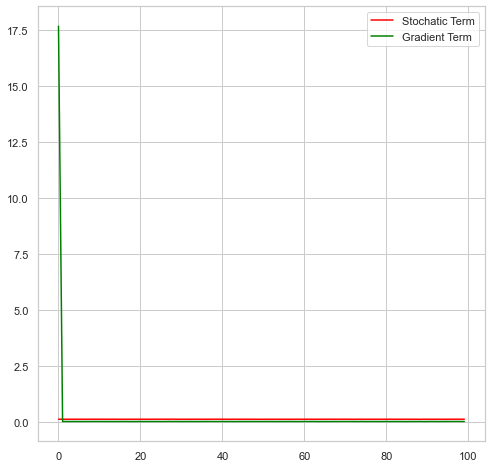

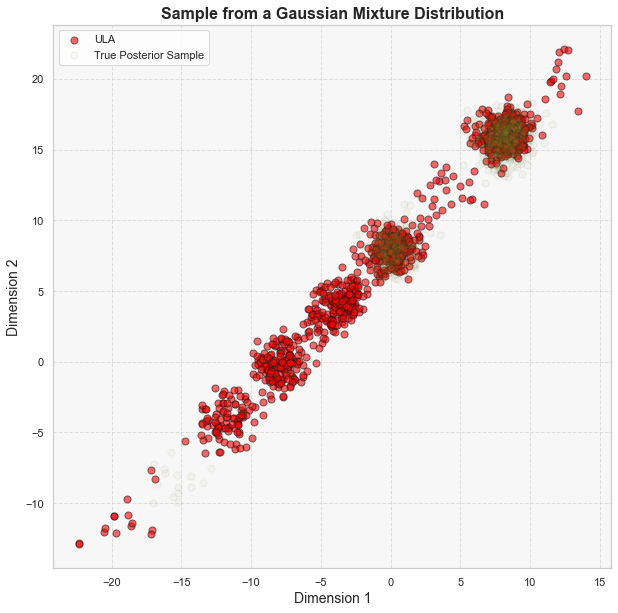

100%|██████████| 700/700 [00:33<00:00, 21.15it/s]


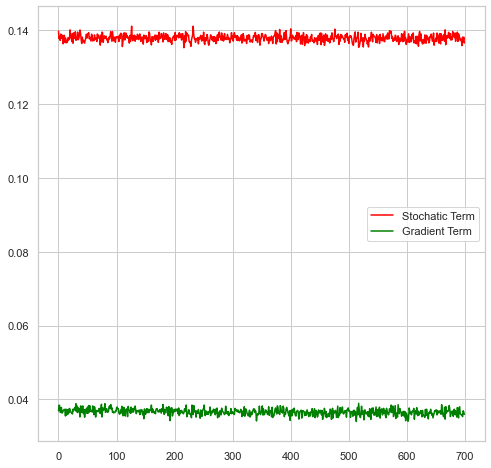

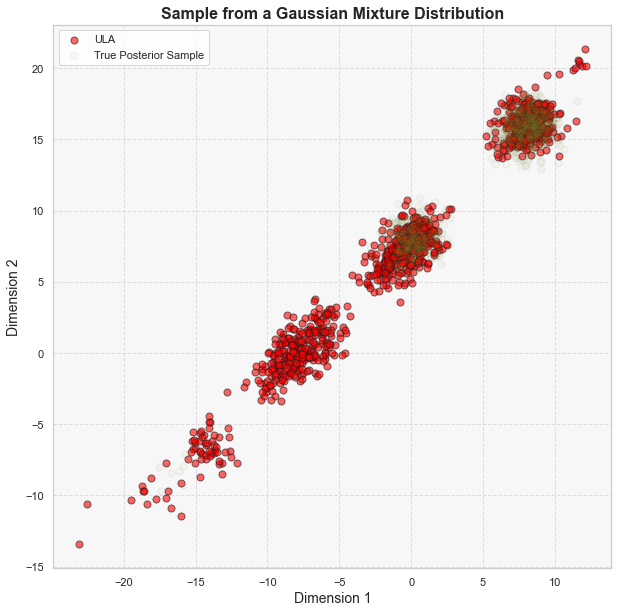

100%|██████████| 2000/2000 [00:36<00:00, 54.33it/s]


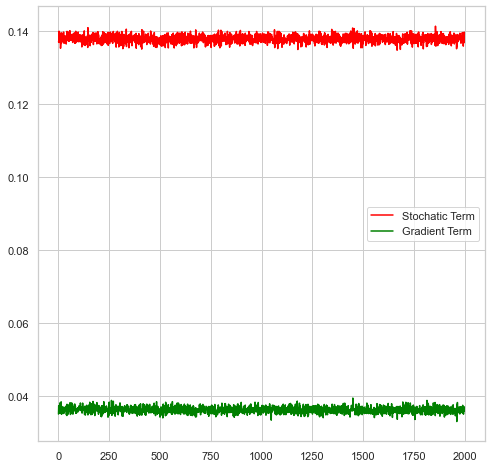

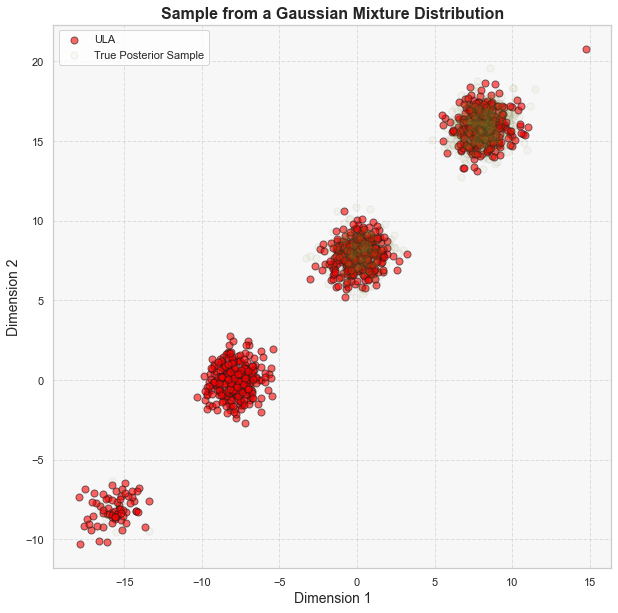

100%|██████████| 7000/7000 [02:49<00:00, 41.29it/s]


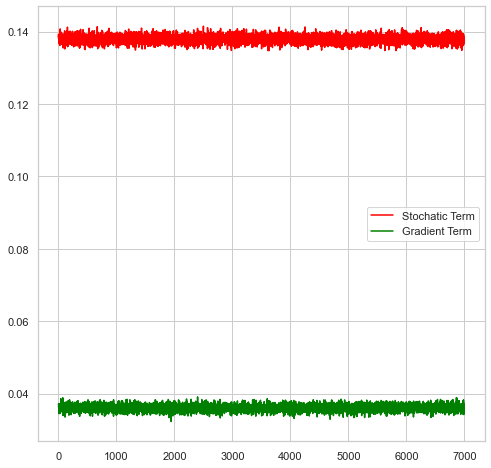

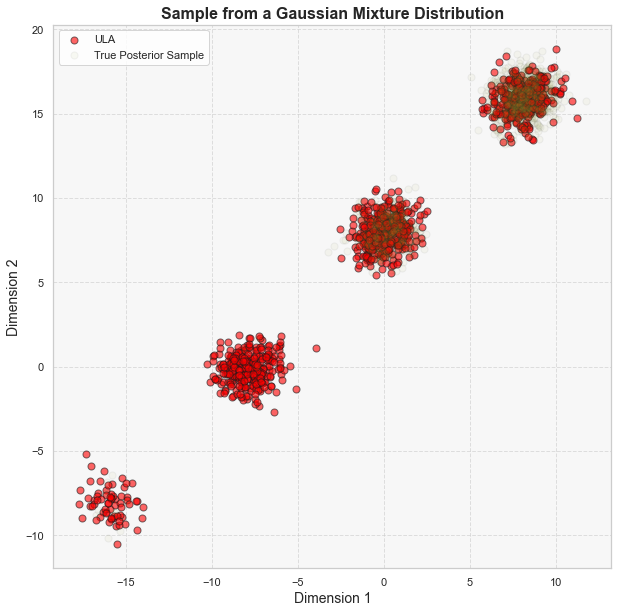

array([[ 7.68767776e+00,  1.68963147e+01,  5.86961428e+00, ...,
         1.64190178e+01,  7.45743834e+00,  1.41339765e+01],
       [ 6.94557095e+00,  1.33124768e+01,  8.91585356e+00, ...,
         1.69405640e+01,  8.98121633e+00,  1.63537837e+01],
       [-2.63033812e-01,  8.04768135e+00, -7.41837644e-01, ...,
         9.27158674e+00, -1.63619581e-01,  7.23357411e+00],
       ...,
       [ 5.44502583e-01,  8.06129868e+00, -6.54552550e-01, ...,
         6.14554699e+00, -5.63631037e-03,  7.69637339e+00],
       [-7.13081328e+00,  1.03374794e+00, -7.73045954e+00, ...,
         1.21759063e+00, -6.72609410e+00,  4.18739521e-01],
       [ 8.90953055e+00,  1.65295062e+01,  9.12903249e+00, ...,
         1.55276396e+01,  7.37519763e+00,  1.54064428e+01]])

In [123]:
sample_init = sample_prior_dx(1000, centers_prior, covariances_prior, theta_star)

ULA_post_dx(sample_init, 0.001, 100, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, plot = True)
ULA_post_dx(sample_init, 0.001, 700, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, plot = True)
ULA_post_dx(sample_init, 0.001, 2000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, plot = True)
ULA_post_dx(sample_init, 0.001, 7000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, plot = True)

INFINIMENT PLUS RAPIDE WTFFFF

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:47<00:00, 41.72it/s]


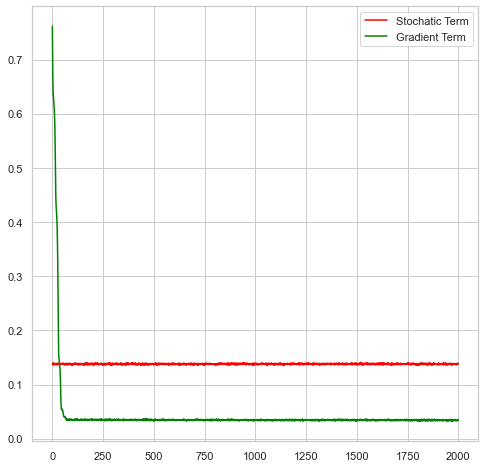

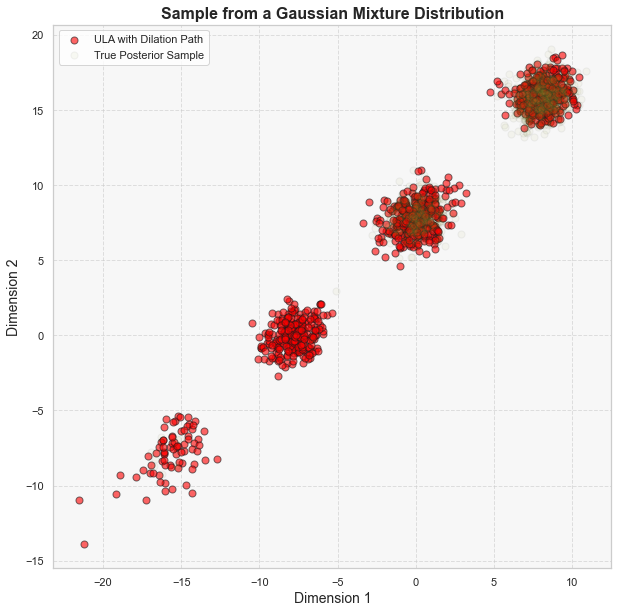

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/Interacting Particles - MMLE/experiment_functions.py:124: RuntimeWarning: invalid value encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
100%|██████████| 2000/2000 [00:43<00:00, 46.18it/s]


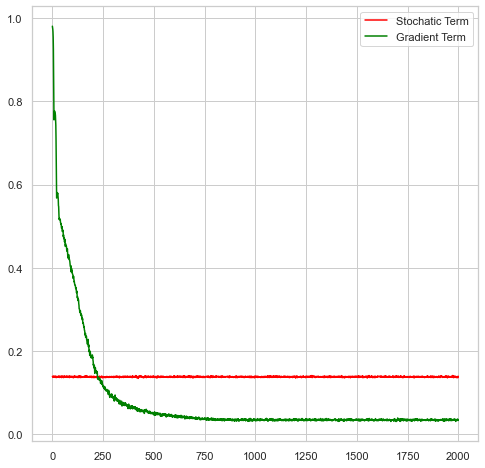

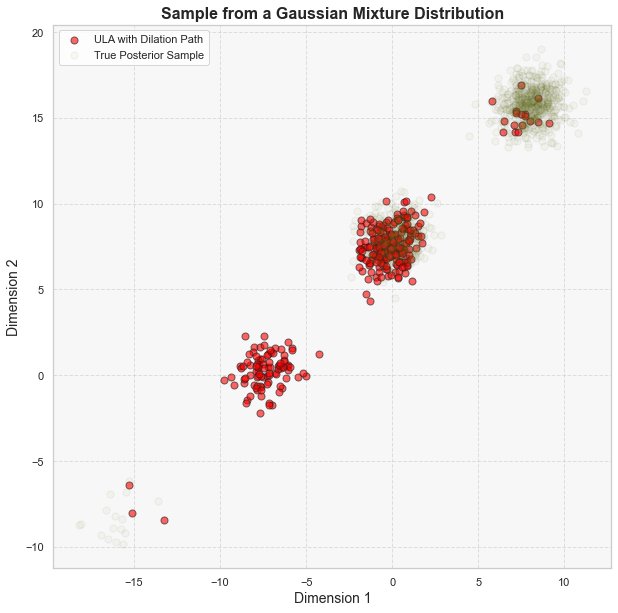

100%|██████████| 2000/2000 [00:46<00:00, 43.23it/s]


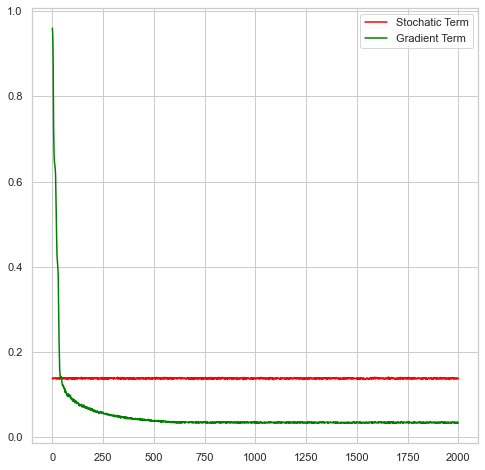

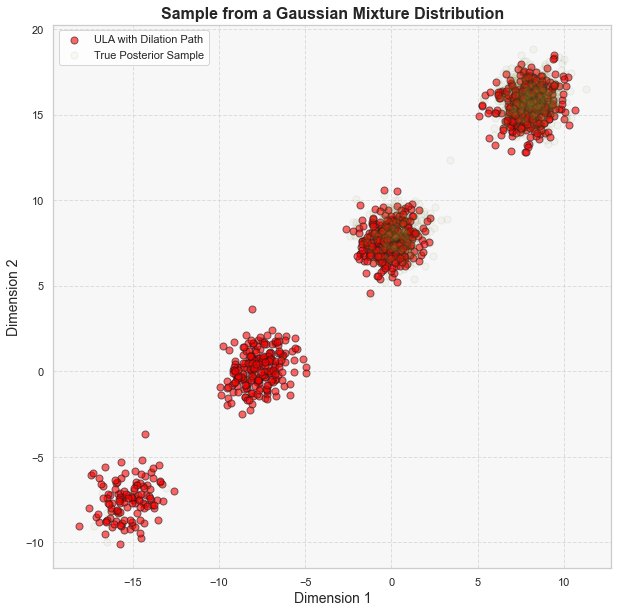

100%|██████████| 2000/2000 [00:30<00:00, 65.01it/s]


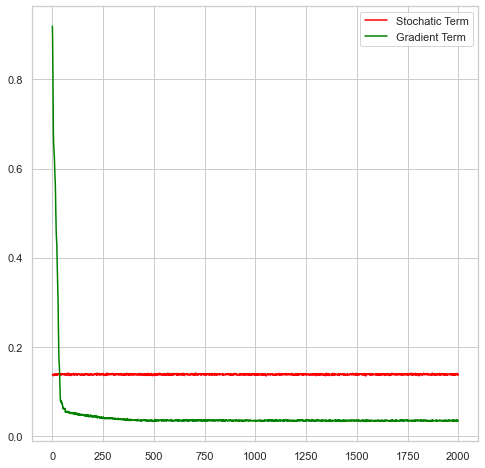

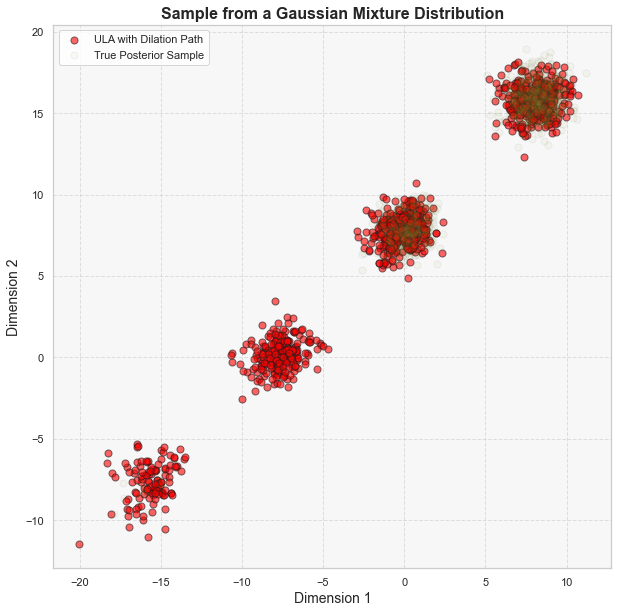

array([[  8.1839839 ,  14.58841987,   7.99497915, ...,  16.60596748,
          6.73825725,  17.20375177],
       [-15.72615726,  -7.69459137, -15.17980945, ...,  -6.9307636 ,
        -16.33304229,  -6.78044104],
       [  7.80745564,  15.26672659,   8.71274205, ...,  14.84158899,
          7.48459832,  16.29611546],
       ...,
       [ -6.3004762 ,   1.73549723,  -6.40795526, ...,   0.10665423,
         -5.73585602,   0.32794879],
       [  0.32985412,   8.33454992,  -0.44349103, ...,   8.05156451,
          0.91671666,   7.15634252],
       [ -1.31848685,   8.48975499,  -0.03133732, ...,   5.90408819,
          0.41980921,   6.39982708]])

In [134]:
sample_init = sample_prior_dx(1000, centers_prior, covariances_prior, theta_star)

ULA_dilation_exp(np.copy(sample_init), 0.001, 2000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, 1, 1, plot = True)
ULA_dilation_exp(np.copy(sample_init), 0.001, 2000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, 0.2, 1, plot = True)
ULA_dilation_exp(np.copy(sample_init), 0.001, 2000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, 0.4, 1, plot = True)
ULA_dilation_exp(np.copy(sample_init), 0.001, 2000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, 0.6, 1, plot = True)



100%|██████████| 4000/4000 [01:21<00:00, 49.24it/s]


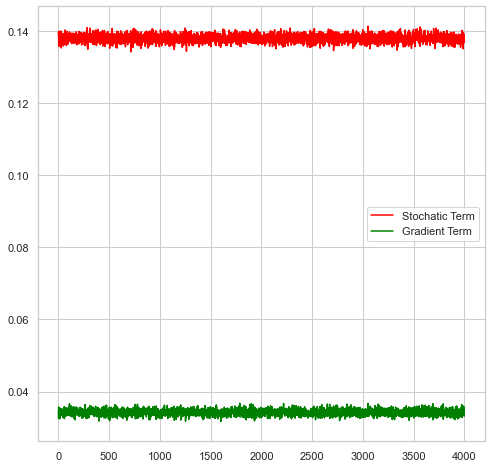

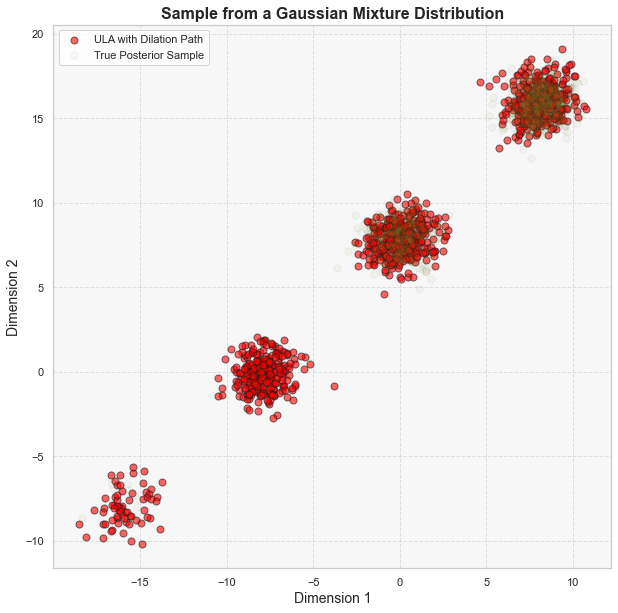

array([[ -1.3675816 ,   7.64630485,  -0.89576627, ...,   7.28638042,
          1.11931109,   6.74146083],
       [ -8.06884392,   1.19567701,  -8.17065889, ...,  -0.43743624,
         -7.0508173 ,   0.34929758],
       [-17.12076581,  -9.01198933, -16.64191254, ...,  -8.62951895,
        -16.99908415,  -7.48751891],
       ...,
       [ -7.88739222,   0.40239472,  -7.08177306, ...,  -1.12367754,
         -9.2895778 ,  -1.60999163],
       [  8.16317422,  16.10806155,   8.68370018, ...,  16.70918776,
          7.66298308,  17.20567565],
       [ -7.75111604,  -0.61993465,  -7.67023687, ...,  -2.77773733,
         -8.57346374,   0.93538798]])

In [110]:
ULA_dilation_exp(sample_init, 0.001, 4000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, 1, 1, plot = True)

Pas forcément ultra mieux ça a juste convergé instant mais chelou car même pas de dilation là -> les graphiques de l'ampleur de tous les termes sont bizarres. En fait le ULA normal c'est juste le gradient tend vers 0 instant et donc ne progresse plus...

Mais du coup le taming c'est pas censé faire ça puisque ça peut que baisser le pas...

100%|██████████| 100/100 [00:03<00:00, 30.20it/s]


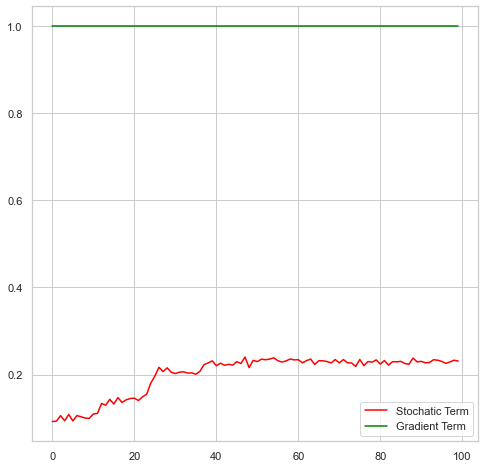

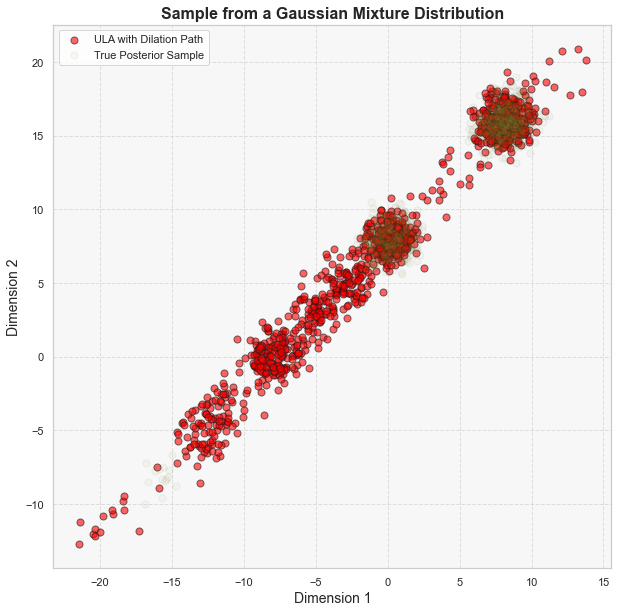

100%|██████████| 1000/1000 [00:30<00:00, 32.96it/s]


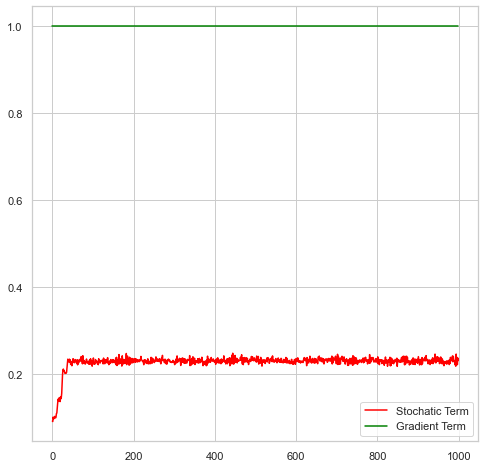

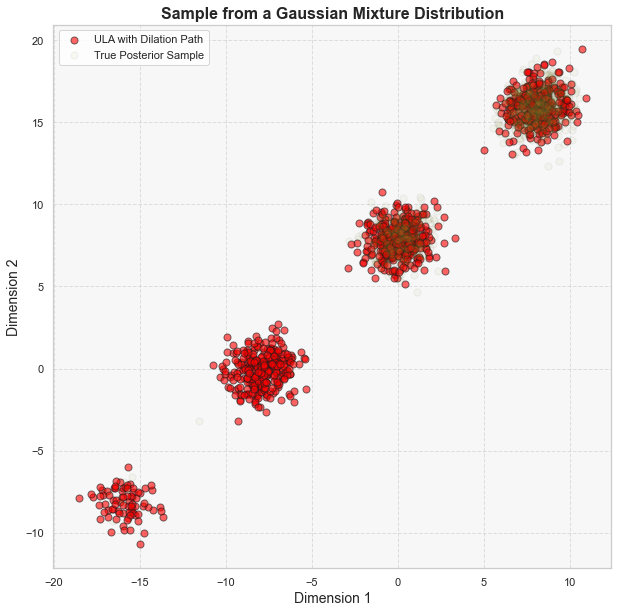

100%|██████████| 1000/1000 [00:34<00:00, 29.33it/s]


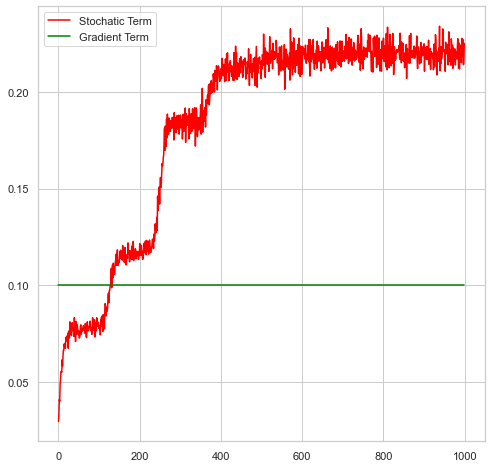

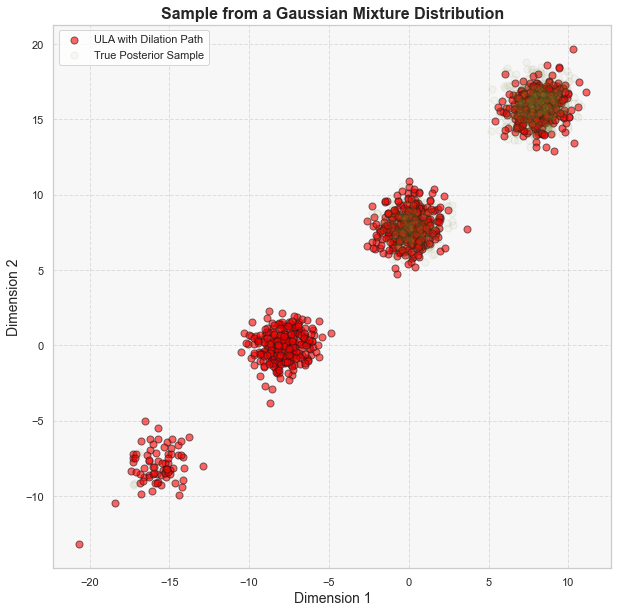

100%|██████████| 1000/1000 [00:37<00:00, 26.87it/s]


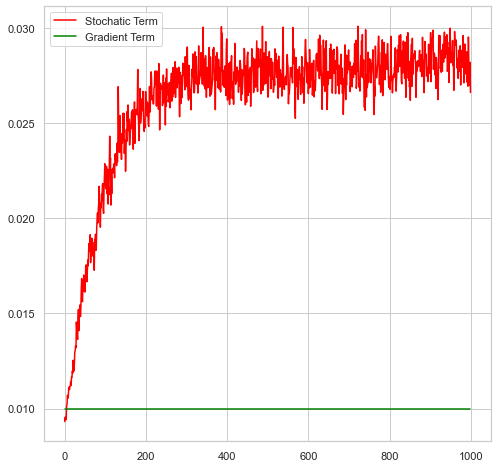

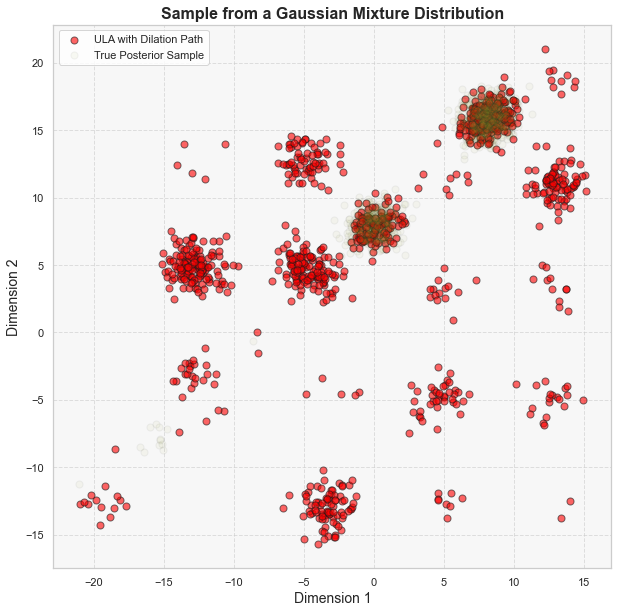

array([[-4.82433384,  6.55329047, -4.46635323, ...,  3.42963134,
        -4.69524414,  6.31179652],
       [ 0.5376595 ,  8.36553163,  0.66203919, ...,  8.83774362,
         0.58128118,  7.51020014],
       [ 0.81750632,  6.64678755,  1.90431905, ...,  8.68372939,
         0.39772089, 10.12506832],
       ...,
       [ 8.19689652, 17.02824998,  6.9774748 , ..., 16.01345236,
        10.05665325, 14.16241849],
       [-3.9163099 ,  3.51275275, -4.58940431, ...,  4.25240641,
        -5.08299587,  6.16922488],
       [ 0.23391261,  7.90546214,  0.02801953, ...,  8.77773395,
         1.49241785,  7.93395262]])

In [137]:
sample_init = sample_prior_dx(1000, centers_prior, covariances_prior, theta_star)

ULA_dilation_exp_adapt(np.copy(sample_init), 0.001, 100, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, 1, 1, 1, 100)
ULA_dilation_exp_adapt(np.copy(sample_init), 0.001, 1000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, 1, 1, 1, 100)
ULA_dilation_exp_adapt(np.copy(sample_init), 0.001, 1000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, 1, 1, 0.1, 100)
ULA_dilation_exp_adapt(np.copy(sample_init), 0.001, 1000, centers_prior, covariances_prior, theta_star, y_obs, sigma_y, H_star, 1, 1, 0.01, 100)

Now that we know everything about sampling according the posterior distribution : 
- step size max to converge
- Reel time that we need to converge

We need to make sure that the model is identifiable and that we can solve the problem and then find an example such that ULA cannot sample efficiently from the posterior distribution so the dilation is useful and it is a good example. 

------------------------------------------------------------------------------------------------------------------------------------------
In this part, several Interacting Particles Algorithms are used to estimate the Maximum Marginal Likelihood of the previous model, from N observations ${Y_1, ..., Y_N}$. 

We know that $\nabla_\theta U_\theta(x, y) = - \nabla_\theta \log p_\theta(x, y)$, and that the gradient of the log joint density $ \log p_\theta(x, y) $ with respect to the parameter $ \theta_j $ is given by:

$
\frac{\partial \log p_\theta(x, y)}{\partial \theta_j} = \frac{\mathcal{N}(x \mid \mu_j, I)}{\sum_{k=1}^K \theta_k \mathcal{N}(x \mid \mu_k, I)}.
$

First, we define the function to proceed a Particle Gradient Descent to solve this problem and we make sure that, with a sample form the "true" posterior, it converges to the right parameter ? 


In [186]:
def grad_theta_GMM(theta, sample, centers, covariances): 

    sample_size = sample.shape[0]
    dim_var = sample.shape[1]
    nb_centers = centers.shape[0]

    grad = np.zeros((sample_size, nb_centers))

    eval_sample = evaluate_gaussian_mixture(sample, theta, centers, covariances)
    
    for i in range(nb_centers): 

            grad[:, i] = multivariate_normal.pdf(sample, mean = centers[i], cov = covariances[i]) / eval_sample

    return grad

No handles with labels found to put in legend.


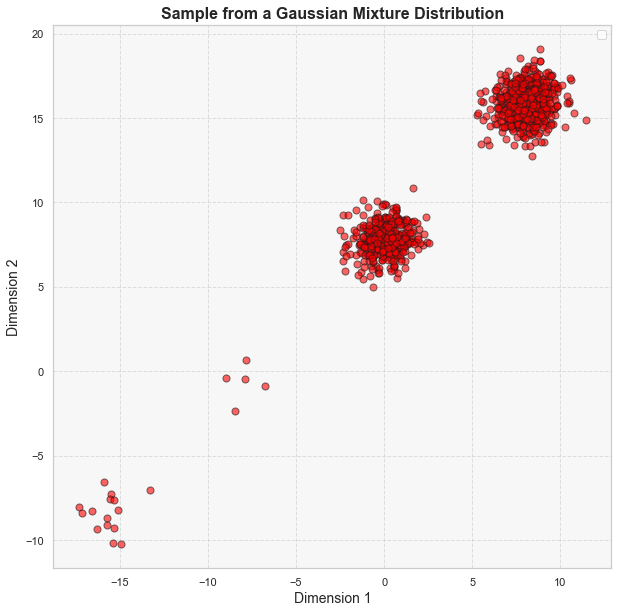

No handles with labels found to put in legend.


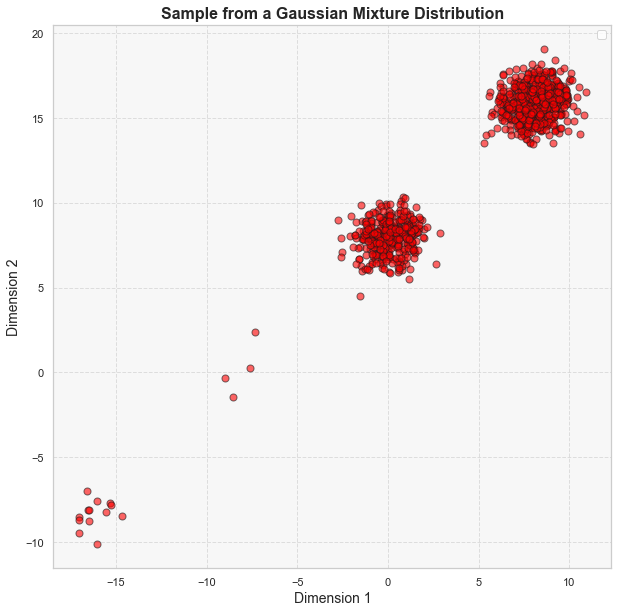

In [206]:
c, cov, w = post_params_dx(H_star, sigma_y, centers_prior, covariances_prior, theta_star, y_obs, plot = False)
plot_sample_dx(sample_prior_dx(1000, c, cov, w))
c_2, cov_2, w_2 = post_params_dx(H_star, sigma_y, c, cov, w, y_obs, plot = False)
plot_sample_dx(sample_prior_dx(1000, c_2, cov_2, w_2))

In [204]:
sample_init = sample_prior_dx(10000, centers_prior, covariances_prior, weights_prior)

a = np.mean((np.sum(grad_theta_GMM(theta_star, sample_init, centers_prior, covariances_prior), axis = 0) / 10000))

sample_init_true = sample_prior_dx(10000, centers_prior, covariances_prior, theta_star)

b = np.mean((np.sum(grad_theta_GMM(theta_star, sample_init_true, centers_prior, covariances_prior), axis = 0) / 10000))

sample_post = sample_prior_dx(10000, centers_truepost, covariances_truepost, theta_star)

c = np.mean((np.sum(grad_theta_GMM(theta_star, sample_post, centers_prior, covariances_prior), axis = 0) / 10000))

a, b, c

(15.930348779042722, 0.9732946261279964, 11.269895144788233)

In [169]:
def PGD_GMM(nb_particles, nb_iter, step_size, centers_prior, covariances_prior, weights_prior, theta_0, sigma_y, y_obs, plot = False, plot_true_theta = None, coeff_theta = 1) : 

    theta_t = theta_0

    weights_t = weights_prior

    dx = theta_0.shape[0]

    nb_components = centers_prior.shape[0]

    sample = sample_prior_dx(nb_particles, centers_prior, covariances_prior, weights_prior)

    theta_traj = np.zeros((nb_iter, nb_components))

    for i in tqdm(range(nb_iter)) : 

        grad = ((1/sigma_y**2) * theta_t[:, np.newaxis] * (y_obs - np.dot(theta_t, sample.T))).T 

        grad += grad_multimodal_opti(sample, weights_t, centers_prior, covariances_prior) 

        grad_update = step_size * grad
        
        #Noise
        noise =  np.sqrt(2 * step_size) * np.random.randn(nb_particles, dx)

        sample += grad_update + noise 

        grad_theta = grad_theta_GMM(weights_t, sample, centers_prior, covariances_prior) 

        grad_theta_update = np.sum(grad_theta, axis = 1) 

        weights_t = weights_t - (step_size * coeff_theta / nb_particles) * grad_theta_update 

        theta_traj[i] = weights_t

        if np.sum(np.isnan(sample)) // dx > 0.9*nb_particles:

            print('Too many NaN in the sample')
            
            return sample, theta_t, theta_traj

    if plot : 

        centers_post, covariances_post, weights_post = post_params_dx(theta_t, sigma_y, centers_prior, covariances_prior, plot_true_theta, y_obs)
        
        sample_post = sample_prior_dx(1000, centers_post, covariances_post, weights_post)
        
        plot_sample_dx(sample, "PDG Sample", sample_post, "True Posterior Sample")

        #plot
        plt.figure(figsize=(10, 8))

        plt.plot(theta_traj[:, 0], theta_traj[:, 1], 'o-', markersize=4, label='Theta Trajectory')

        for i in range(1, len(theta_traj)):

            plt.arrow(theta_traj[i-1, 0], theta_traj[i-1, 1], 
                    theta_traj[i, 0] - theta_traj[i-1, 0], 
                    theta_traj[i, 1] - theta_traj[i-1, 1], 
                    head_width=0.05, head_length=0.1, fc='blue', ec='blue')
            
        plt.scatter(plot_true_theta[0], plot_true_theta[1], color='red', s=100, zorder=5, label='True Theta (1st 2 Dimensions)')
        plt.text(plot_true_theta[0], plot_true_theta[1], s = f"({plot_true_theta[0]}, {plot_true_theta[1]})" , fontsize=12, verticalalignment='bottom', horizontalalignment='right')

        plt.xlabel('Theta Dimension 1')
        plt.ylabel('Theta Dimension 2')
        plt.title(f'Trajectory of Theta in 2D - Step Size {step_size}')
        plt.legend()
        plt.grid(True)
        plt.show() 

    print(f'At the end, the number of NaN in the final sample of particle is {np.sum(np.isnan(sample)) // dx}')

    return weights_t - weights_prior#sample, theta_t, theta_traj


In [177]:
PGD_GMM(1000, 1000, 0.0001, centers_truepost, covariances_truepost, weights_prior, H_star, sigma_y, y_obs, plot = True, plot_true_theta = theta_star, coeff_theta = 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

 18%|█▊        | 184/1000 [00:09<00:36, 22.37it/s]/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_32151/4053210643.py:13: RuntimeWarning: invalid value encountered in true_divide
  grad[i] = multivariate_normal.pdf(sample, mean = centers[i], cov = covariances[i]) / eval_sample
 19%|█▊        | 186/1000 [00:09<00:42, 19.35it/s]

Too many NaN in the sample


(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([-1,  1, -1,  1, -1,  1, -1,  1, -1,  1]),
 array([[0.039905  , 0.03989684, 0.03989996, ..., 0.039917  , 0.03988682,
         0.0399075 ],
        [0.03980977, 0.03979352, 0.0397978 , ..., 0.03983668, 0.0397728 ,
         0.03981479],
        [0.03971432, 0.0396873 , 0.03969873, ..., 0.03975868, 0.03966041,
         0.03972186],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]))

In [ ]:
def PGD_GMM(nb_particles, nb_iter, step_size, centers_prior, covariances_prior, weights_prior, theta_0, sigma_y, y_obs, plot = False, plot_true_theta = None, coeff_theta = 1) : 
    """
    This function executes the Particle Gradient Descent in the context of our experiment. Given :
    - The number of particles
    - The number of iterations
    - The step size
    - Parameters of the prior distribution
    - The observed data point "y"
    - The initializing theta_0
    """

    theta_t = theta_0

    dx = theta_0.shape[0]

    #centers_init, covariances_init, weights_init = post_params_dx(theta_0, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
    #sample = sample_prior_dx(nb_particles, centers_init, covariances_init, weights_init)
    sample = sample_prior_dx(nb_particles, centers_prior, covariances_prior, weights_prior)

    time_SDE = 0

    theta_traj = np.zeros((nb_iter, dx))

    for i in tqdm(range(nb_iter)) : 

        #We don't need to compute the parameters of the posteriori distribution given the updated theta because we use another formula
        #centers_post, covariances_post, weights_post = post_params(theta_t, sigma_y, centers_prior, covariances_prior, weights_prior)

        time_SDE += step_size

        ## on prend le gradient selon x de la posterior actualisée avec theta_t et qui est aussi une mixture Gaussienne
        grad = ((1/sigma_y**2) * theta_t[:, np.newaxis] * (y_obs - np.dot(theta_t, sample.T))).T 

        grad += grad_multimodal_opti(sample, weights_prior, centers_prior, covariances_prior) 

        grad_update = step_size * grad
        
        #Noise
        noise =  np.sqrt(2 * step_size) * np.random.randn(nb_particles, dx)

        sample += grad_update + noise #Warning sign

        #MAJ THETA we need a fct that compute gradient of the potential wrt to theta

        grad_theta = grad_theta_GM(sample, theta_t, y_obs, sigma_y) #renvoie un vecteur avec tous les gradients

        grad_theta_update = np.sum(grad_theta, axis = 0) ## ON MULTIPLIE CHAQUE PARTICLE A SON PAS SPECIFIQUE

        theta_t = theta_t - (step_size * coeff_theta / nb_particles) * grad_theta_update 

        theta_traj[i] = theta_t

        if np.sum(np.isnan(sample)) // dx > 0.9*nb_particles:

            print('Too many NaN in the sample')
            
            return sample, theta_t, theta_traj

    if plot : 

        centers_post, covariances_post, weights_post = post_params_dx(plot_true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
        
        sample_post = sample_prior_dx(1000, centers_post, covariances_post, weights_post)
        
        plot_sample_dx(sample, "PDG Sample", sample_post, "True Posterior Sample")

        #plot
        plt.figure(figsize=(10, 8))

        plt.plot(theta_traj[:, 0], theta_traj[:, 1], 'o-', markersize=4, label='Theta Trajectory')

        for i in range(1, len(theta_traj)):

            plt.arrow(theta_traj[i-1, 0], theta_traj[i-1, 1], 
                    theta_traj[i, 0] - theta_traj[i-1, 0], 
                    theta_traj[i, 1] - theta_traj[i-1, 1], 
                    head_width=0.05, head_length=0.1, fc='blue', ec='blue')
            
        plt.scatter(plot_true_theta[0], plot_true_theta[1], color='red', s=100, zorder=5, label='True Theta (1st 2 Dimensions)')
        plt.text(plot_true_theta[0], plot_true_theta[1], s = f"({plot_true_theta[0]}, {plot_true_theta[1]})" , fontsize=12, verticalalignment='bottom', horizontalalignment='right')

        plt.xlabel('Theta Dimension 1')
        plt.ylabel('Theta Dimension 2')
        plt.title(f'Trajectory of Theta in 2D - Step Size {step_size}')
        plt.legend()
        plt.grid(True)
        plt.show() 

    print(f'At the end, the number of NaN in the final sample of particle is {np.sum(np.isnan(sample)) // dx}')

    return sample, theta_t, theta_traj
